# Partial Discharge Signal Denoising using Optimized Wavelet [Part 2]

## *Non-Dominated Sorting Genetic Algorithm (NSGA2)*

This Python script performs the **NSGA2** functions required to **optimize** the **wavelet parameters** and **thresholding functions** for the **wavelet denoising** of the noisy PD signals.
The pymoo NSGA2 tool is a powerful & fast multi-objective genetic algorithm with the possibility of good convergence and robustness, when set-up properly.

The following functions are performed in this script:
1. Define 1D-signal as x,y representation of time-amplitude.
2. Obtain peak height and position from singular PD pulses.
3. Definition of signal similarity measures/indices to be used as objectives for optimization [CC, SNR, MSE, peak height & peak position deviation].
4. Wavelet denoising, featuring decomposition at 7 levels, QCTF thresholding function, and reconstruction.
5. Element-wise problem definition to be used in the NSGA2 function, set to perform minimizations.
6. Visualisation of objective space with a color-mapped 3D scatter plot [SNR, MSE, CC].
7. Optimal solution selection.

### 1. Installation of modules

Use the command 'pip install [module name]' in the terminal to install required modules.

In [1]:
import warnings
warnings.filterwarnings("ignore")
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install pywavelets
!pip install pymoo
!pip install scipy
!pip install scikit-learn

You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\melro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


### 2. Import statements

In [2]:
import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import pywt
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from scipy.signal import find_peaks, resample
from sklearn.metrics import mean_squared_error
from math import log10
from scipy.stats import pearsonr
import operator
from pymoo.decomposition.asf import ASF
from timeit import default_timer as timer

### 3. Initialization of timer

Timer allows us to determine the elapsed time for this Python script.

In [3]:
start = timer()

### 4. Initialization of input signals

Initialize input signals here. Only edit ***'clean_file_path'***; noisy signal will be automatically found
Input signals include the clean and noisy signal, which is used for signal similarity measures/indices.
numpy's ***ravel()*** allows for the signals to be transformed to a 1-D signal [contiguous flattened array].
Additionally, upsampling is done on the clean signal [from 99 to 4000 samples] to allow for a 1-to-1 comparison with the noisy signal.
Upsampling the clean signal may negatively impact the signal similarity indices by returning false results 
[not fully tested; almost negligible impact], but should theoretically be better than downsampling the noisy signal
and potentially losing high frequency information.

In [4]:
clean_file_path = 'PD_Data/Pulses/Void3_Pulse5.txt'
file_name = os.path.splitext(clean_file_path)[0][15:]
print("Accessed: "+file_name)
filename_cutoff1 = file_name.find('_')
filename_cutoff2 = file_name.find('.')
noisy_file_path = "PD_Data/NoisyPulses/"+file_name[:filename_cutoff1]+"_NoisyPulse"+file_name[filename_cutoff2:]+".txt"

clean_csv = pd.read_csv(clean_file_path)
clean_data = pd.DataFrame(clean_csv).to_numpy()
clean_data = clean_data.ravel()
clean_signal = clean_data
clean_signal_upsampled = resample(clean_signal, 4000)

noisy_csv = pd.read_csv(noisy_file_path)
noisy_data = pd.DataFrame(noisy_csv).to_numpy()
noisy_data = noisy_data.ravel()
noisy_signal = noisy_data

Accessed: Void3_Pulse5


### 5. Definition of signal transformation & peak extraction functions

In [5]:
def define_samples_as_array(data):
    """
    Function converts the 1D-signal into x,y representation; y is magnitude, x is sample number.
    - Sampling time is (no. of sampling points)/(sampling frequency) = 1s; obtained from presentation slides
    - No. of sampling points = 500002 samples
    - Sampling frequency is 500002 samples/sec = 0.5MHz
    """

    x = np.linspace(0,len(data), len(data))
    data = pd.DataFrame(data).to_numpy()
    data = data.ravel()
    y = data

    return x,y

def get_peaks(x, y):
    """
    Function obtains peak height and peak position from the input x & y values, derived from define_samples_as_array().
    - Height is minimum required height
    - Threshold is minimum required threshold, ie vertical distance from neighbour
    - Prominence measures how much a peak stands out from the surrounding baseline
    """

    peaks = find_peaks(y, height=max(y))
    height = peaks[1]['peak_heights']
    peak_pos = x[peaks[0]]

    return height, peak_pos

# Obtaining height and peak position [actual/desired height after denoising] of the clean signal
actl_height = get_peaks(define_samples_as_array(clean_signal_upsampled)[0],
                        define_samples_as_array(clean_signal_upsampled)[1])[0][0]
actl_pk_pos = get_peaks(define_samples_as_array(clean_signal_upsampled)[0],
                        define_samples_as_array(clean_signal_upsampled)[1])[1][0]

### 6. Definition of signal similarity measures/indices functions

We take into account the **CC**, **MSE**, **SNR**, **peak height** & **peak position** to evaluate similarity with the original signal.
Measures ordered by significance: **CC** > **MSE** >= **SNR** > **peak height** >= **peak position**.

In [6]:
def CC(clean, noisy):
    """
    Function returns the Pearson correlation coefficient based on the clean and noisy signal.
    Similar signals will result in a value of +1, indicating perfect correlation.
    A value of -1 indicates inverse correlation, while 0 indicates no correlation.
    As such, we intend to optimize this closest to +1 [maximization; assuming CC calculated cannot exceed +1]
    """
    return pearsonr(clean,noisy)[0]

def MSE(clean, noisy):
    """
    Function returns the mean-squared error between the clean and noisy signal.
    Similar signals will result in a value closest to 0.
    As such, we intend to optimize this closest to 0 [minimization]
    """
    return (mean_squared_error(clean, noisy))

def SNR(clean, noisy):
    """
    Function returns the signal-to-noise ratio based on the clean and noisy signal.
    SNR calculation method obtained from: https://github.com/hrtlacek/SNR/blob/main/SNR.ipynb
    Using method 2; subtract difference in power between noisy and clean signal to obtain noise power.
    Then, SNR is the ratio of signal power to noise power.
    """

    clean_power = sum(abs(clean) ** 2) / len(clean)
    denoised_power = sum(abs(noisy) ** 2) / len(noisy)

    noise_power = float(denoised_power) - float(clean_power)    # finding noise power
    x = (denoised_power - noise_power) / (noise_power)  # SNR; (signal power alone)/(noise power alone)

    # x = clean_power/noise_power   # method technically works when compared with this line; results in same SNR
    # ans = log1p(abs(x))
    # ans2 = expm1(ans) - 1
    # return 10*ans2

    return 10 * log10(abs(x))

def pk_hght_match(height):
    closest_hght_diff = abs(actl_height - height)
    return closest_hght_diff

def pk_pos_match(pk_pos):
    closest_pk_diff = abs(actl_pk_pos - pk_pos)
    return closest_pk_diff

### 7. Definition of wavelet denoising function

Takes in **20 filter bank** arguments and **3 thresholding** arguments, resulting in **23 variables** to optimize.
Effects of filter bank length has not been thoroughly analysed, but a length of **10** for both **low-pass decomposition filter**
and **low-pass reconstruction filter** exhibits adequate denoising performance and low computation time.
The **high-pass filters** are merely **mirrored** versions of the **low-pass filters** for a **biorthogonal wavelet**.
**Biorthogonal wavelets** allow for a **linear phase**, hence, given the computational power at our disposal and the need for the
best denoising performance, we opt for the more complex approach as compared to an orthogonal wavelet.
**7 decomposition levels** exhibit decent denoising performance; the **QCTF [quadratic curve TF] thresholding function** used is
reportedly better than the regular soft & hard functions for abruptly changing signals like ECG, which is similar to PD.

In [7]:
def wavelet_denoising(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w):
    """
    Function performs wavelet denoising with a custom wavelet at 7 decomposition levels, with
    QCTF thresholding function: Link: https://ieeexplore.ieee.org/document/7158597.
    All values are optimized using NSGA2 with pymoo.
    - 'a' to 't' are wavelet filter bank values
    - 'u' is the curve coefficient for the QCTF
    - 'v' is the curve end point
    - 'w' is the threshold value
    """

    # Filter bank initialization
    LoD = [a,b,c,d,e,f,g,h,i,j]
    HiD = LoD[::-1]
    LoR = [k,l,m,n,o,p,q,r,s,t]
    HiR = LoR[::-1]

    my_filter_bank = [LoD, HiD, LoR, HiR]
    my_wavelet = pywt.Wavelet('Custom Wavelet', filter_bank=my_filter_bank)

    # Decomposition of signal
    new_coeffs = pywt.wavedec(noisy_signal, wavelet=my_wavelet, level=7, mode='per')

    # QCTF thresholding
    a = u
    ld_e = v
    ld = w

    # ld_e is curve end point, a is curve coefficient
    b = ((ld_e) / (ld_e - ld)) - a * (ld_e + ld)
    c = (ld * ld_e) * ((1 / (ld - ld_e)) + a)

    for idx, val in enumerate(new_coeffs):
        for idx2, x in enumerate(new_coeffs[idx]):
            if (abs(x) < ld):
                new_coeffs[idx][idx2] = 0
            elif (ld < abs(x) < ld_e):
                new_coeffs[idx][idx2] = a * (x ** 2) + b * x + c
            else:
                new_coeffs[idx][idx2] = x

    # Reconstruction of signal post-thresholding
    return pywt.waverec(new_coeffs, my_wavelet, mode='per')

### 8. Implementation of pymoo NSGA2 optimization

**NSGA2** is ideal for multi-objective optimization problems. Definition includes **problem**, **algorithm [NSGA2]**, **termination criterion**, &
**optimization** method [**minimize** or **maximize**]. Additionally, visualization of solutions are also included.

In [8]:
class ProblemWrapper(ElementwiseProblem):
    """
    Element-wise problem definition inheriting from ElementwiseProblem.
    5 objectives using the similarity measures/indices have been defined.
    The SNR and CC has been maximized, hence we use a minimize function for everything else and invert
    the SNR and CC objective alone.
    - _evaluate is responsible for the evaluation function
    - __init__ method is used to define the number of variables, objectives, & constraints, as well as the lower and
      upper bounds for the objective inputs
    """

    def __init__(self):
        super().__init__(n_var=23,
                         n_obj=5,
                         n_constr=0,
                         xl=np.array([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1, -20, -20, -20]),
                         xu=np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1, 20, 20, 20]))

    def _evaluate(self, x, out, *args, **kwargs):
        # Definition of all 5 objectives
        denoising = wavelet_denoising(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12],
                                      x[13], x[14], x[15], x[16], x[17], x[18], x[19], x[20], x[21], x[22])

        f1 = SNR(clean_signal_upsampled, denoising)
        f2 = MSE(clean_signal_upsampled, denoising)
        f3 = CC(clean_signal_upsampled, denoising)

        u1, u2 = define_samples_as_array(denoising)
        o1, o2 = get_peaks(u1, u2)

        try:
            f4 = pk_hght_match(o1[0])
            f5 = pk_pos_match(o2[0])
        except:
            f4 = pk_hght_match(10 ** 6)
            f5 = pk_pos_match(10 ** 6)

        f1 = -f1
        f3 = -f3

        out["F"] = np.column_stack([f1, f2, f3, f4, f5])

# Problem initialization
problem = ProblemWrapper()

# Algorithm initialization
algorithm = NSGA2()

# Termination criterion initialization
stop_criteria = ('n_gen', 20)

# Optimization initialization
res = minimize(problem=problem,
               algorithm=algorithm,
               termination=stop_criteria,
               seed = 1,
               save_history = True,
               verbose = True,
               eliminate_duplicates = True
               )

# NSGA2 output [X is the input value, F is the objectives]
X = res.X
F = res.F

print(X)
print(F)

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
fl = nF.min(axis=0)
fu = nF.max(axis=0)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.show_compile_hint = False

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     100 |      26 |            - |            -
    2 |     200 |      44 |          nan |            f
    3 |     300 |      69 |  0.179392836 |        ideal
    4 |     400 |      72 |          nan |            f
    5 |     500 |      98 |          nan |            f
    6 |     600 |     100 |          nan |            f
    7 |     700 |     100 |          nan |            f
    8 |     800 |     100 |          nan |            f
    9 |     900 |     100 |  0.185777770 |        ideal
   10 |    1000 |      19 |          INF |        nadir
   11 |    1100 |      18 |  0.010673745 |            f
   12 |    1200 |      21 |  0.028479258 |        ideal
   13 |    1300 |      19 |  0.085976451 |        ideal
   14 |    1400 

### 9. Selection of optimal solution

Utilises the **compromise programming** method as explained in the pymoo [**'Getting Started - Part III: Multi-Criteria Decision Making'**](https://pymoo.org/getting_started/part_3.html)
page. The best solution with regards to the **Augmented Scalariztion Function [ASF]** is selected by considering the inverse of weights associated with
each objective. More information about this optimal solution selection method can be found in the hyperlink above. Finally, the **filter bank** variables
associated with the optimal **objective** values obtained are saved into a .txt file with the same file name as the clean pulse.

In [9]:
weights = np.array([0, 0.95, 0.05, 0, 0])
decomp = ASF()
I = decomp.do(nF, 1/weights).argmin()
print("Best regarding ASF: Point \nI = %s\nF = %s" % (I, F[I]))
print("Best solution: \nX = %s" % (X[I]))

optimal_sol = []
for opt_idx, opt_val in enumerate(X[I]):
    optimal_sol.append(opt_val)

output = "\n".join(map(str, optimal_sol))
output_file_path = "PD_Data/FilterBank/"+file_name[:filename_cutoff1]+"_Pulse"+file_name[filename_cutoff2:]+".txt"

with open(output_file_path, 'w') as f:
    f.writelines(output)

Best regarding ASF: Point 
I = 25
F = [-2.26800510e+00  1.47454382e-02 -9.00634266e-01  3.45705548e-01
  2.00050013e+01]
Best solution: 
X = [ 1.32986335e-01  9.36847885e-02 -4.18247235e-01 -3.30841965e-01
 -3.15595943e-01  3.65017744e-01  5.82115943e-01  5.01029862e-02
  4.02752298e-02  4.92725718e-01 -2.38584558e-01 -3.11866069e-01
  1.77078703e-01  2.02980532e-01  2.09535133e-01  7.07339501e-02
  4.63718886e-01  2.01817098e-01 -5.35658786e-03  3.03594816e-01
 -1.31290753e+01 -1.55973108e+01 -3.71000325e+00]


### 10. Visualisation of the objective space

Uses a 3D scatter plot highlighting the **SNR** [x-axis], **MSE** [y-axis], & **CC** [z-axis] values with a colormap.
Additionally, the **optimal solution** is also plotted in the same 3D space.

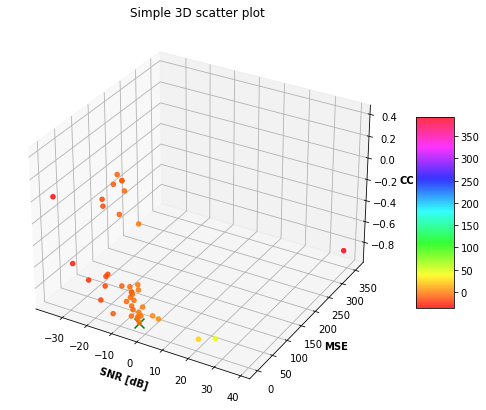

In [10]:
plot_vals1 = res.F[:,0]
plot_vals2 = res.F[:,1]
plot_vals3 = res.F[:,2]
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")

my_cmap = plt.get_cmap('hsv')
#ax.scatter3D(plot_vals1, plot_vals2, plot_vals3, color="green")

sctt = ax.scatter3D(plot_vals1, plot_vals2, plot_vals3,
                    alpha = 0.8,
                    c = (plot_vals1 + plot_vals2 + plot_vals3),
                    cmap = my_cmap,
                    marker ='o')

sctt2 = ax.scatter3D(F[I, 0], F[I, 1], F[I, 2],
                     alpha=1,
                     s = 100,
                     color = 'green',
                     marker = 'x')

ax.set_xlabel('SNR [dB]', fontweight ='bold')
ax.set_ylabel('MSE', fontweight ='bold')
ax.set_zlabel('CC', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
plt.title("Simple 3D scatter plot")
plt.show()

### 11. End of script

Completion status is presented, and timer is ended here.

In [11]:
end = timer()
elapsed = end-start
print("\n===NSGA2 COMPLETED===")
print("Elapsed Time: ",elapsed,"secs\n")


===NSGA2 COMPLETED===
Elapsed Time:  6.109479300001112 secs



## *Next: Wavelet Denoising using Optimized Wavelet Denoising Parameters*

[**Part 3**](https://github.com/MelroyCaeiro/PD-Denoising-using-Optimized-Wavelet/blob/main/Denoising.ipynb) uses the optimal wavelet and thresholding function parameters determined by the NSGA2 function to perform
wavelet denoising on the noise-contaminated signal. Click the hyperlink above to continue to the next step of the optimized wavelet denoising process.